**Objetivo: Vamos a crear una LSTM capaz de clasificar si una secuencia de novela pertenece a Benito Pérez Galdós o a Emilia Pardo Bazán**

Guión del ejercicio
1. Importar las librerias
2. Descargar el texto(novelas)
3. Preparar el texto máximo de 250 palabras
4. Crear el dataframe
5. 80% entrenamiento, 20%validación
6. Ponemos a punto todas las variables
7. Tokenizar
8. Probamos que funciona el tokenizador
9. Padding
10. Creamos la RNN- LSTM 👶
11. Compilamos, entrenamos...
12. Predecimos

In [3]:
URLS = [
    ("galdos", "http://www.gutenberg.org/cache/epub/52392/pg52392.txt"),  # Miau
    ("galdos", "http://www.gutenberg.org/cache/epub/15725/pg15725.txt"),  # Doña Perfecta
    ("galdos", "http://www.gutenberg.org/cache/epub/17013/pg17013.txt"),  # Fortunata y Jacinta
    ("bazan", "https://www.gutenberg.org/files/65632/65632-0.txt"),  # La prueba
    ("bazan", "https://www.gutenberg.org/files/58059/58059-0.txt"),  # La Madre Naturaleza
    ("bazan", "https://www.gutenberg.org/cache/epub/17491/pg17491.txt"),  # La Tribuna
]

## 1.- Importar las librerías

In [4]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## 2.- Descargar texto

In [5]:
galdos=""
bazan =""
for autor, url in tqdm(URLS):
  texto =requests.get(url).text
  empieza="START OF "
  acaba = "END OF "
  texto =texto[texto.index(empieza):texto.index(acaba)]

  if autor =="galdos":
    galdos += "\n" + texto
  else:
    bazan += "\n" + texto


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


## 3.- Preparar el texto máximo de 250 palabras

In [6]:
n=250

galdos_split=galdos.split()
trocitos_galdos= [galdos_split[i:i+n] for i in range(0, len(galdos_split),n)]

bazan_split=bazan.split()
trocitos_bazan= [bazan_split[i:i+n] for i in range(0, len(bazan_split),n)]

In [7]:
#¿Pregunta al aire?
#¿Quién hacía las novelas más largas?
#Benito

galdos_longitud=len(trocitos_galdos)
bazan_longitud=len(trocitos_bazan)
galdos_longitud, bazan_longitud

(2426, 868)

## 4.- Preparar el dataframe

Ahora vamos a crear un **dataframe**
con una columna con  el texto y
 labels, 1 si es galdos y un 0 bazan



In [8]:
# Lista de trozos de texto
trocitos = ["Este es el primer trozo", "seguido del segundo", "y aquí terminamos"]

# Unir los trozos en una sola cadena, separados por un espacio
texto_unido = " ".join(trocitos)

# Mostrar el resultado
print(texto_unido)

Este es el primer trozo seguido del segundo y aquí terminamos


In [9]:
def preparar_dataframe(text_chunks, label):
    """
    Crea un DataFrame a partir de trozos de texto, asigna una etiqueta,
    mezcla los datos aleatoriamente y reinicia el índice.

    Args:
    - text_chunks: Lista de listas de strings (cada sublista es un trozo de texto).
    - label: Entero, la etiqueta a asignar a todos los textos.

    Returns:
    - DataFrame de pandas con los textos y las etiquetas.
    """

    # Crear el DataFrame a partir de los trozos de texto
    df = pd.DataFrame([" ".join(chunk) for chunk in text_chunks], columns=["text"])

    # Asignar la etiqueta
    df = df.assign(label=label)

    # Mezclar aleatoriamente y reiniciar el índice
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# Usar la función para preparar los DataFrames de Galdós y Bazán
galdos_df = preparar_dataframe(trocitos_galdos, label=1)
bazan_df = preparar_dataframe(trocitos_bazan, label=0)

In [10]:
galdos_df

,text,label
0,que fue a verle después de anochecido. No sabí...,1
1,Los verdaderamente unidos no existían más que ...,1
2,somos [5] amigos. --Gracias. No vale la pena. ...,1
3,salido!» pero no tenía noticia de esta palabra...,1
4,él ningún afán grande ni esa curiosidad sedien...,1
...,...,...
2421,"--Basta, no siga usted--dijo Maxi, ceñudo, cor...",1
2422,ginete. Verdad es que a quien de casta le vien...,1
2423,álbum para enseñárselo á Paca y á _Canelo_. Bi...,1
2424,"frenética, revertida otra vez bruscamente a la...",1


In [11]:
bazan_df

,text,label
0,resuelto adelantar el regreso a Madrid. Â«Feli...,0
1,mostrando su agilidad y fuerza en el duro ejer...,0
2,Un golpe de gente que desembocaba en la calle ...,0
3,"como la de los sordomudos, me llamÃ³; sin duda...",0
4,ver más de cerca al capitán general portador d...,0
...,...,...
863,"un puro, lo cual ejecutó con bastante soltura;...",0
864,cualquier canto de la senda. Iba el seÃ±or Ant...,0
865,ver cuatro coles? --Si usted no tiene ocupaciÃ...,0
866,"a menear los palitroques, hay que arreglar los...",0


## 5.- 80% entrenamiento, 20%validación

In [12]:
# Lo que vamos a hacer es hacer el 80% del train
train_df=pd.concat(
    [galdos_df[:int(galdos_longitud*.8)],bazan_df[:int(bazan_longitud*.8)]],
    ignore_index=True
    ).sample(frac=1).reset_index(drop=True)

In [13]:
train_df

,text,label
0,"y serenidad, fue que se oyeron los pasos de do...",1
1,"el pueril instrumento--. ¡Ah!, calavera, así m...",1
2,la casa del cura un bienestar modesto. AsÃ­ se...,0
3,propio de los del segundo de la derecha. En el...,1
4,"y mi sombrero de copa, que había estrenado par...",1
...,...,...
2629,Le daba miedo aquella medicina. Tomola Maxi y ...,1
2630,los amorosos 22 brazos del tío Licurgo. Frisab...,1
2631,tales vocablos a personas dispuestas a unirse ...,1
2632,"_onomatopoeia for the rustling sound of a fan,...",1


In [14]:
eval_df = pd.concat(
    [galdos_df[int(galdos_longitud*.8):], bazan_df[int(bazan_longitud*.8):]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
eval_df

,text,label
0,place. =colophón= (_A._ =colofón=) _m_ colopho...,1
1,"y confianzuda, y como el espacio es allí tan r...",1
2,el portal. «Tenemos mucho que hablar--le dijo ...,1
3,"traer provisión de árnica, reconocerle bien la...",1
4,algo más. Hoy no te supiste la lección de Gram...,1
...,...,...
655,"25 =por cuya razón=: cf. n. on p. 24, l. 7. =1...",1
656,"que es ahora, que quieras que no, tomo cartas ...",1
657,"ni los muertos; a su lado, con largo redingote...",0
658,"nada, y sin embargo... Pero es preciso vigilar...",1


In [15]:
train_df['label'].value_counts()

label
1    1940
0     694
Name: count, dtype: int64

In [16]:
eval_df['label'].value_counts()

label
1    486
0    174
Name: count, dtype: int64

## 6.- Establecer las variables para tokenizar

### Parámetros de red

**vocab_size** = cómo de largo queremos sea. Si es muy pequeño, habrá muchos
tokens que no conocemos, si es muy largo... muuuuchooo tiempo entrenado

**max_length**=> Tamaño de la secuencia.

**embedding_dim** => Como de grande van a ser los vectores que van a representar
a nuesto vocabulario.

**trunc_type** => truncar (post= al final)
**padding_type** => si es mas corta de 250.... post
**oov_tok** <OOV> Out of vocabulary



In [17]:
vocab_size=5000
embedding_dim=64
max_length=250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

## 7.- Tokenización

In [19]:
train_articles=train_df['text'].tolist()
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(train_articles)

word_index=tokenizer.word_index


In [20]:
# Crea el diccionario
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'de': 2,
 'que': 3,
 'la': 4,
 'y': 5,
 'el': 6,
 'a': 7,
 'en': 8,
 'no': 9,
 'se': 10}

## 8.- Prueba de funcionamiento de la tokenización

In [21]:
train_sequencies = tokenizer.texts_to_sequences(train_articles)

In [25]:
print(train_sequencies[0])

[5, 1277, 115, 3, 10, 2530, 12, 596, 2, 67, 151, 5, 13, 158, 3888, 1689, 731, 3, 198, 229, 59, 181, 633, 30, 97, 2, 1, 1, 18, 46, 16, 17, 424, 4, 1, 22, 1206, 4, 3639, 1, 4, 715, 4, 248, 87, 597, 1, 67, 151, 8, 4, 164, 43, 32, 3092, 7, 1939, 11, 47, 18, 1, 15, 558, 5, 35, 663, 40, 463, 3, 32, 1, 9, 153, 74, 23, 37, 137, 1253, 4, 181, 5, 6, 429, 2531, 14, 358, 1, 1, 214, 57, 123, 330, 3, 15, 664, 422, 37, 1, 154, 1, 149, 1, 87, 9, 395, 24, 1, 9, 27, 9, 981, 66, 165, 79, 307, 140, 46, 235, 1512, 3, 4, 2532, 18, 4150, 72, 92, 9, 4804, 1, 170, 14, 748, 847, 156, 629, 42, 453, 4424, 3, 920, 9, 1940, 297, 8, 549, 86, 4, 3247, 5, 88, 3, 19, 1, 519, 267, 1, 156, 1, 25, 3, 552, 94, 15, 1, 2, 4425, 5, 1, 3, 23, 583, 171, 38, 1001, 6, 650, 113, 2, 265, 1779, 1, 30, 57, 123, 7, 48, 2, 67, 1, 1, 235, 88, 1278, 27, 87, 2656, 19, 1, 229, 5, 179, 4426, 7, 1, 7, 15, 1549, 8, 268, 64, 1, 7, 270, 43, 18, 1, 6, 113, 28, 9, 46, 66, 5, 57, 214, 1, 30, 535, 179, 1941, 3, 13, 181, 4151, 138, 2, 476, 24, 1, 23

In [23]:
train_articles[0]

'y serenidad, fue que se oyeron los pasos de doña Lupe, y su voz temerosa: «Mira, Papitos, que voy allá...». --Tía, venga usted... Está de jarana... --¡Acusón!--le dijo por lo bajo la chicuela al coger la lámpara--, feón. --La culpa la tienes tú--añadió severamente doña Lupe, en la puerta--, porque te pones a jugar con ella, le ríes las gracias, y ya ves. Cuando quieres que te respete, no puede ser. Es muy mal criada. La tía y el sobrino hablaron un instante. «¿También vendrás tarde esta noche? Mira que las noches están muy frías. Estas heladas son crueles. Tú no estás para valentías». --No, si no siento nada. Nunca he estado mejor--dijo Rubín, sintiendo que la timidez le ganaba otra vez. --No hagamos simplezas... Hace un frío horrible. ¡Qué año tan malo! ¿Creerás que anoche no pude entrar en calor hasta la madrugada? Y eso que me eché encima cuatro mantas. ¡Qué atrocidad! Como que estamos entre las _Cátedras de Roma y Antioquía_, que es, según decía mi Jáuregui, el peor tiempo de Madr

## 9.- Padding

In [26]:
# Aplicar padding
train_padded = pad_sequences(train_sequencies, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [29]:
validation_articles = eval_df['text'].tolist()
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

## 10.- Construir Red Neuronal

- sequential API de Keras
- Embedding vocab_size * embedding_dim
- LSTM(de manera bidireccional)
- Densa con sigmoid y de tipo clasificación binaria

In [31]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394369 (1.50 MB)
Trainable params: 394369 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 11.- Compilar y entrenar Red Neuronal

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
num_epochs=3
train_labels = train_df['label'].tolist()
val_labels = eval_df['label'].tolist()

train_label=np.array(train_labels)
validation_label = np.array(val_labels)

In [38]:
history = model.fit(
    train_padded, train_label, epochs=num_epochs,
    validation_data=(validation_padded, validation_label), verbose=2)


Epoch 1/3


83/83 - 11s - loss: 0.5508 - accuracy: 0.7430 - val_loss: 0.2352 - val_accuracy: 0.9364 - 11s/epoch - 138ms/step
Epoch 2/3
83/83 - 7s - loss: 0.1133 - accuracy: 0.9639 - val_loss: 0.1022 - val_accuracy: 0.9485 - 7s/epoch - 81ms/step
Epoch 3/3
83/83 - 7s - loss: 0.0388 - accuracy: 0.9856 - val_loss: 0.0317 - val_accuracy: 0.9879 - 7s/epoch - 81ms/step


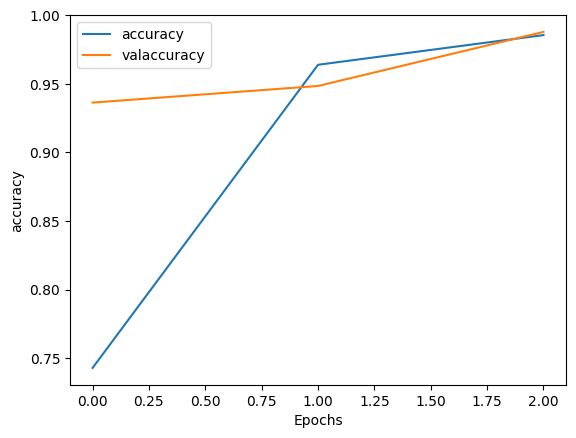

In [42]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val'+string])
  plt.show()

plot_graphs(history, "accuracy")


## 12.- Predicciones

Si el resultado de la predicción es < que 0,5 quiere decir que ha detectado que el texto es de Emilia.

Si el resultado de la predicción es > que 0,5 quiere decir que ha detectado que el texto es de Benito.


In [51]:
txt = ['''
para que el triunfo fuese completo era menester que a Maxi le entrase una enfermedad asquerosa, repugnante y pestífera, de esas que ahuyentan hasta a los más allegados. Ella, entonces, daría pruebas de ser tan ángel como otra cualquiera, y tendría alma, paciencia, valor y estómago para todo. «Y entonces vería _esa_ si aquí hay perfecciones o no hay perfecciones, y que cada una es cada una... Lo malo sería que no lo viese, porque acá no ha de venir...». Maximiliano la distrajo de esta meditación, dando quejidos profundos. Ya conocía aquello su mujer y sabía el remedio, que era volverlo suavemente del otro lado... «¡Qué sueño!--murmuró Maxi medio despierto--. Soñaba que te habías marchado... y yo te había cogido de un pie, y tú tirabas, y yo tiraba más, y tirando se me rompía la bolsa del aneurisma, y todo el cuarto se llenaba de sangre, todo el cuarto, hasta el techo...». Le arrulló para que se durmiera, y ella se durmió también. Levantose temprano porque tenía que trabajar. Después de las nueve, cuando entró en la alcoba a ver si a su marido se le ofrecía alguna cosa, este se estaba vistiendo, y en una disposición de ánimo muy distinta de la que tuviera la noche anterior. No sólo parecía recobrado de su debilidad, sino que estaba inquieto, ágil y como si acabara de tomar un excitante muy enérgico. En cuanto entró su mujer, se fue derecho a ella, abotonándose el cuello de la camisa, y en tono
''']

seq=tokenizer.texts_to_sequences(txt)
padded=pad_sequences(seq, maxlen=max_length)
pred=model.predict(padded)
print(pred)

1/1 [==============================] - 0s 69ms/step
[[0.99755496]]


## Mejoras
- utf-8
- quitar stopwords
- aumentar el tamaño de vocabulario
- max_length
- WordEmbedding
- Cuantos más datos, mucho mejor